In [1]:
from __future__ import print_function
from ae_classifier import AE_classifier, read_data
import numpy as np
from PIL import Image
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Read the training data
imgs, labels, classes = read_data('../images_background')

In [3]:
sample_image = imgs[0]
print('Image size:', sample_image.shape)
print('Max. pixel value:', sample_image.max())
print('Min. pixel value:', sample_image.min())

Image size: (105, 105)
Max. pixel value: 1.0
Min. pixel value: 0.0


It can be seen that the image is single channel, and the pixel values are already normalized.

In [4]:
print('Sample class names:\n', '\n'.join(classes[:5]))
print('Number of classes: ', len(classes))

Sample class names:
 ../images_background/Gujarati/character42
../images_background/Gujarati/character45
../images_background/Gujarati/character11
../images_background/Gujarati/character16
../images_background/Gujarati/character29
Number of classes:  964



### Some specifics about the model (The complete details can be found in the ae_classifier.py file):
*It is my preference to work using a object oriented approach, thus, while I explain the basis of my model here, I have added detailed comments to the .py files themselves*

1. It is hypothesized that if the model can reconstruct the image, then it has learned important semantic features about image. Correct classification is also an indication for the same.
2. The model can be described in 3 parts, the Encoder, the Decoder and the Classifier:
    * The Encoder outputs the feature representations of the input images
    * The Decoder tries to reconstruct the original image from the generated features by the encoder
    * The Classifier tries to output a probability distribution over the classes using the features from the encoder
3. There are two losses we optimize over:
    * Reconstruction loss: The difference in the original image and the generated image, measured as the mean-squared error or the cross-entropic loss (cross entropic loss was found to work much better in our case)
    * Softmax cross-entropic loss: The error between the predicted class (softmax of the Classifier output) and the actual class label for the image.
4. We train the encoder for the combined loss, the classifier for the classification loss only and the decoder for the reconstruction loss only. If the hypothesis is true, the model should learn important features about the image.
5. The encoder is a stack of **4**, **stride=2**, convolutional layers with **leaky_relu** activations on all layers except the last, which has None.  Each layer uses multiple size kernels and concatenates the results for the final output, specifically **[3,5,7]**. The final output shape is **[batch_size, 4, 4, 192]**
6. The classifier flattens the features to **[batch_size, 3072]**, and applies **2 dense layers** for the final *logit* output.
7. Various architectures were explored for the decoder. Simple deconvolutions with **stride=2**; *Multi-kernel* **stride=2** deconvolutions; **Residual** added deconvolutions. It was observed that the choice of decoder architecture influenced the final test accuracy greatly. The Residual deconvolution seemed to perform the best. The details of it can be found in the 'ops.py' file.
8. Different forms of regularizers were also tested, like, Dropout, Batch Normalizer and Layer Normalizer. It was observed that in our case, using none of them anywhere resulted in the best performance.
9. The model is trained via minimising the combined loss using an **RMSPropOptimizer** with a learning rate of **1e-4**. The gradients are allowed to propagate to all the possible variables (which works exactly in the same way as stated in *4*) 
10. During test time the image is passed through the encoder to yield important features. For comparison, a squared difference between the two feature sets is taken as the semantic distance. The decoder output serves as the reconstruction of the image.

In [5]:
ae_cl = AE_classifier(classes, name='default')

AE_classifier/train/graph/encoder/c0/LeakyRelu/Maximum:0 (?, 32, 32, 24)
AE_classifier/train/graph/encoder/c1/LeakyRelu/Maximum:0 (?, 16, 16, 48)
AE_classifier/train/graph/encoder/c2/LeakyRelu/Maximum:0 (?, 8, 8, 96)
AE_classifier/train/graph/encoder/c3/add:0 (?, 4, 4, 192)
AE_classifier/train/graph/decoder/d0/add:0 (?, 8, 8, 96)
AE_classifier/train/graph/decoder/d1/add:0 (?, 16, 16, 48)
AE_classifier/train/graph/decoder/d2/add:0 (?, 32, 32, 24)
AE_classifier/train/graph/decoder/d3/add:0 (?, 64, 64, 1)
AE_classifier/train/graph/classifier/h0:0 (?, 3072)
AE_classifier/train/graph/classifier/h1/LeakyRelu/Maximum:0 (?, 3072)
AE_classifier/train/graph/classifier/h2/LeakyRelu/Maximum:0 (?, 3072)
AE_classifier/train/graph/classifier/h3/BiasAdd:0 (?, 964)
AE_classifier/inference/graph/encoder/c0/LeakyRelu/Maximum:0 (?, 32, 32, 24)
AE_classifier/inference/graph/encoder/c1/LeakyRelu/Maximum:0 (?, 16, 16, 48)
AE_classifier/inference/graph/encoder/c2/LeakyRelu/Maximum:0 (?, 8, 8, 96)
AE_classifie

In [6]:
# Train a new model or load a previously trained model
# ae_cl.train(imgs, labels)
ae_cl.load()

loading default model...
INFO:tensorflow:Restoring parameters from AE_classifier/default/saves/AE_classifier.ckpt-12040
[16/Oct/2018 18:31:02] INFO - Restoring parameters from AE_classifier/default/saves/AE_classifier.ckpt-12040


Traceback (most recent call last):
  File "/usr/local/Cellar/python@2/2.7.15/Frameworks/Python.framework/Versions/2.7/lib/python2.7/logging/__init__.py", line 868, in emit
    msg = self.format(record)
  File "/usr/local/Cellar/python@2/2.7.15/Frameworks/Python.framework/Versions/2.7/lib/python2.7/logging/__init__.py", line 741, in format
    return fmt.format(record)
  File "/usr/local/Cellar/python@2/2.7.15/Frameworks/Python.framework/Versions/2.7/lib/python2.7/logging/__init__.py", line 465, in format
    record.message = record.getMessage()
  File "/usr/local/Cellar/python@2/2.7.15/Frameworks/Python.framework/Versions/2.7/lib/python2.7/logging/__init__.py", line 329, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Logged from file ae_classifier.py, line 69


True

### Testing out the quality of reconstructions, more alignment with the original image indicates that the model understands the image, thus, a better model

In [7]:
def plot_images_recons(images, recons):
    n = len(images)
    fig = plt.figure(figsize=(10,10))
    for i in range(n):
        img = images[i]
        fig.add_subplot(n, 2, 2*i+1)
        plt.imshow(img)
        recon = recons[i]
        fig.add_subplot(n, 2, 2*i+2)
        plt.imshow(recon)
    plt.show()

In [8]:
num_samples = 4

In [9]:
sample_imgs = random.sample(imgs, num_samples)

In [10]:
sample_recons = ae_cl.img_reconstruction(sample_imgs)

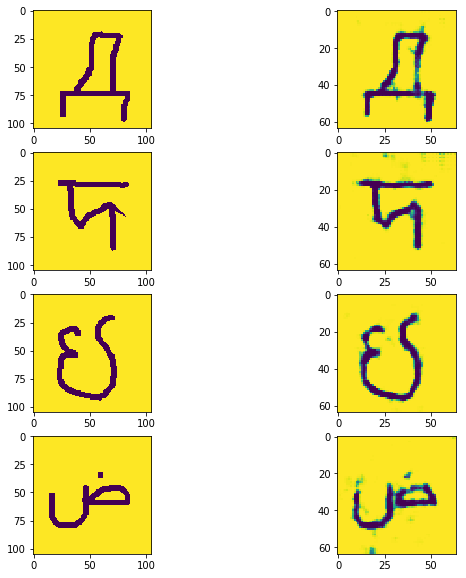

In [11]:
plot_images_recons(sample_imgs, sample_recons)

## Test dataset

In [12]:
test_imgs, test_labels, _ = read_data('../images_evaluation')

In [13]:
sample_test_images = random.sample(test_imgs, num_samples)
sample_test_recons = ae_cl.img_reconstruction(sample_test_images)

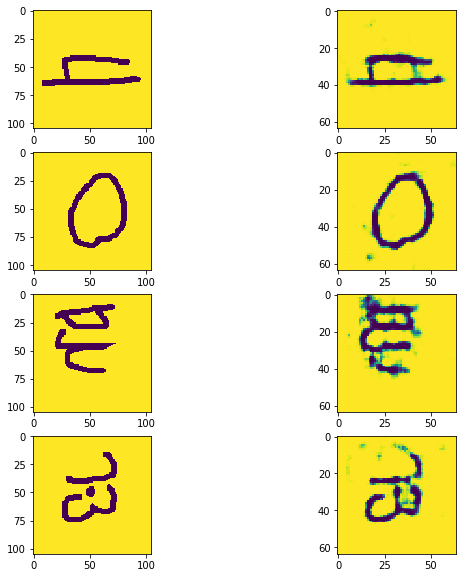

In [14]:
plot_images_recons(sample_test_images, sample_test_recons)

### It can be seen that the reconstrcutions align with the original images. This indicates that the model does indeed 'understand' the characters in the test set

Below code is taken from demo_classification.py file from https://github.com/brendenlake/omniglot

In [15]:
import copy

# Parameters
nrun = 20 # number of classification runs
fname_label = 'class_labels.txt' # where class labels are stored for each run

In [16]:
def classification_run(folder,f_load,f_cost,ftype='cost'):
    # Compute error rate for one run of one-shot classification
    #
    # Input
    #  folder : contains images for a run of one-shot classification
    #  f_load : itemA = f_load('file.png') should read in the image file and process it
    #  f_cost : f_cost(itemA,itemB) should compute similarity between two images, using output of f_load
    #  ftype  : 'cost' if small values from f_cost mean more similar, or 'score' if large values are more similar
    #
    # Output
    #  perror : percent errors (0 to 100% error)
    # 
    assert ((ftype=='cost') | (ftype=='score'))

    # get file names
    with open(folder+'/'+fname_label) as f:
        content = f.read().splitlines()
    pairs = [line.split() for line in content]
    test_files  = [pair[0] for pair in pairs]
    train_files = [pair[1] for pair in pairs]
    answers_files = copy.copy(train_files)
    test_files.sort()
    train_files.sort()	
    ntrain = len(train_files)
    ntest = len(test_files)

    # load the images (and, if needed, extract features)
    train_items = [f_load(f) for f in train_files]
    test_items  = [f_load(f) for f in test_files ]

    # compute cost matrix
    costM = np.zeros((ntest,ntrain),float)
    for i in range(ntest):
        for c in range(ntrain):
            costM[i,c] = f_cost(test_items[i],train_items[c])
    if ftype == 'cost':
        YHAT = np.argmin(costM,axis=1)
    elif ftype == 'score':
        YHAT = np.argmax(costM,axis=1)
    else:
        assert False

    # compute the error rate
    correct = 0.0
    for i in range(ntest):
        if train_files[YHAT[i]] == answers_files[i]:
            correct += 1.0
    pcorrect = 100 * correct / ntest
    perror = 100 - pcorrect
    return perror

In [17]:
def load_img(fn):
    return np.asarray(Image.open(fn), dtype=np.float32)

In [18]:
perror = np.zeros(nrun)
for r in range(1,nrun+1):
    rs = str(r)
    if len(rs)==1:
        rs = '0' + rs
    perror[r-1] = classification_run('run'+rs, load_img, ae_cl.feature_distance, 'cost')
    print(" run " + str(r) + " (error " + str(perror[r-1] ) + "%)")
total = np.mean(perror)
print(" average error " + str(total) + "%")

 run 1 (error 90.0%)
 run 2 (error 95.0%)
 run 3 (error 95.0%)
 run 4 (error 90.0%)
 run 5 (error 90.0%)
 run 6 (error 95.0%)
 run 7 (error 95.0%)
 run 8 (error 95.0%)
 run 9 (error 95.0%)
 run 10 (error 95.0%)
 run 11 (error 80.0%)
 run 12 (error 95.0%)
 run 13 (error 95.0%)
 run 14 (error 95.0%)
 run 15 (error 95.0%)
 run 16 (error 95.0%)
 run 17 (error 95.0%)
 run 18 (error 90.0%)
 run 19 (error 100.0%)
 run 20 (error 90.0%)
 average error 93.25%


### The average error is found to be 93.25%, the state of the art established currently is 93.75% by 'Matching Networks for One Shot Learning'.
During multiple runs the lowest score was found to be 93.00%, this is because of the randomness in initialization of varaibles at each run